In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

In [3]:
# DataSet generation
data_set = dict()

with open("stocks.txt", "r") as f:
    stocks = [line.strip() for line in f if line.strip()]

for stock in stocks:
    df = pd.read_csv(
        f"csv/{stock}_indicators.csv",
        index_col=0,       # use first column ("Date") as index
        parse_dates=[0],    # parse it as datetime
        date_format="ISO8601" #Specify date fromat
    ) 
    # ensure numeric and drop rows with NaNs in target/features
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=['Target'])
    X = df.drop(columns=["Target"])
    Y = df["Target"]

    train_mask = X.index < "2025-01-01"
    test_mask = X.index >= "2025-01-01"
    X_train, X_test = X[train_mask], X[test_mask]
    Y_train, Y_test = Y[train_mask], Y[test_mask]
    
    if len(X_train) == 0 or len(X_test) == 0:
        print(f"Skipping storing {stock}: empty train/test split")
        continue

    
    data_set[stock] = {
        "X_train": X_train,
        "X_test": X_test,
        "Y_train": Y_train,
        "Y_test": Y_test
    }

    print("="*20 + stock + "="*20)
    print(f"Traing size {len(X_train)}")
    print(f"Test size {len(X_test)}\n")

====================AAPL====================
Traing size 2514
Test size 182

====================META====================
Traing size 2514
Test size 182

====================ORCL====================
Traing size 2514
Test size 182

====================MSFT====================
Traing size 2514
Test size 182




=== ElasticNet for AAPL ===
Best params: {'enet__alpha': 0.01, 'enet__l1_ratio': 0.5}
RMSE: 0.0230 | MAE: 0.0147 | R2: -0.0005
Top coefficients:
 Volume         0.0
Return         0.0
RSI            0.0
MACD           0.0
Signal_Line    0.0
STD20          0.0


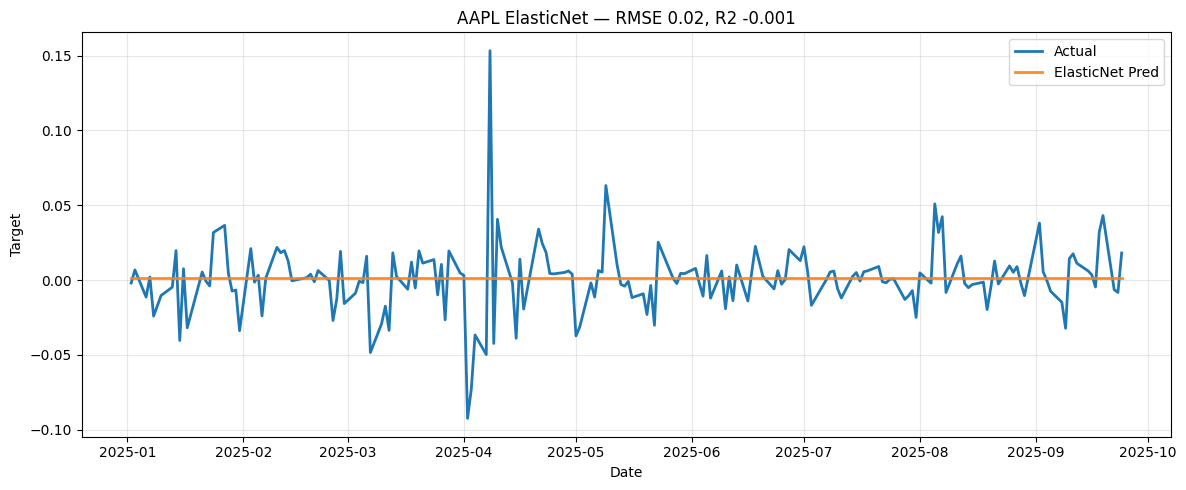


=== ElasticNet for META ===
Best params: {'enet__alpha': 0.01, 'enet__l1_ratio': 0.5}
RMSE: 0.0250 | MAE: 0.0168 | R2: -0.0003
Top coefficients:
 Volume         0.0
Return         0.0
RSI            0.0
MACD           0.0
Signal_Line    0.0
STD20          0.0


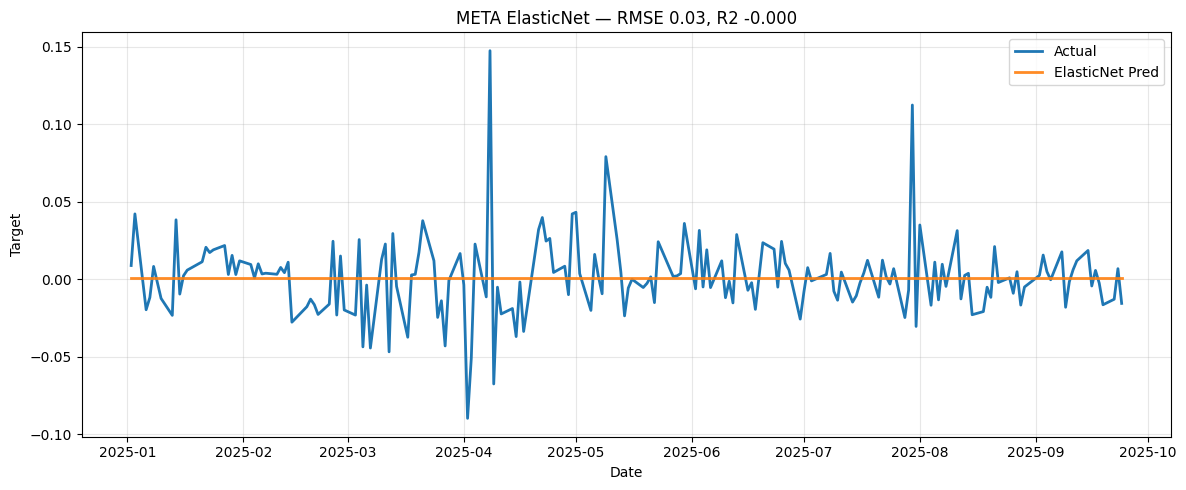


=== ElasticNet for ORCL ===
Best params: {'enet__alpha': 0.01, 'enet__l1_ratio': 0.5}
RMSE: 0.0412 | MAE: 0.0242 | R2: -0.0060
Top coefficients:
 Volume         0.0
Return         0.0
RSI            0.0
MACD           0.0
Signal_Line    0.0
STD20          0.0


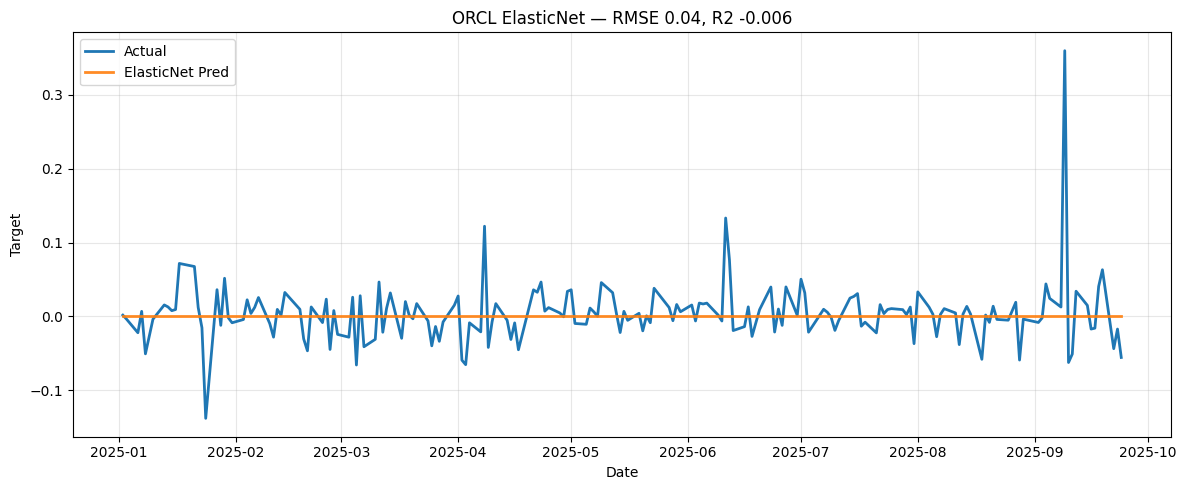


=== ElasticNet for MSFT ===
Best params: {'enet__alpha': 0.01, 'enet__l1_ratio': 0.5}
RMSE: 0.0164 | MAE: 0.0105 | R2: -0.0001
Top coefficients:
 Volume         0.0
Return         0.0
RSI            0.0
MACD           0.0
Signal_Line    0.0
STD20          0.0


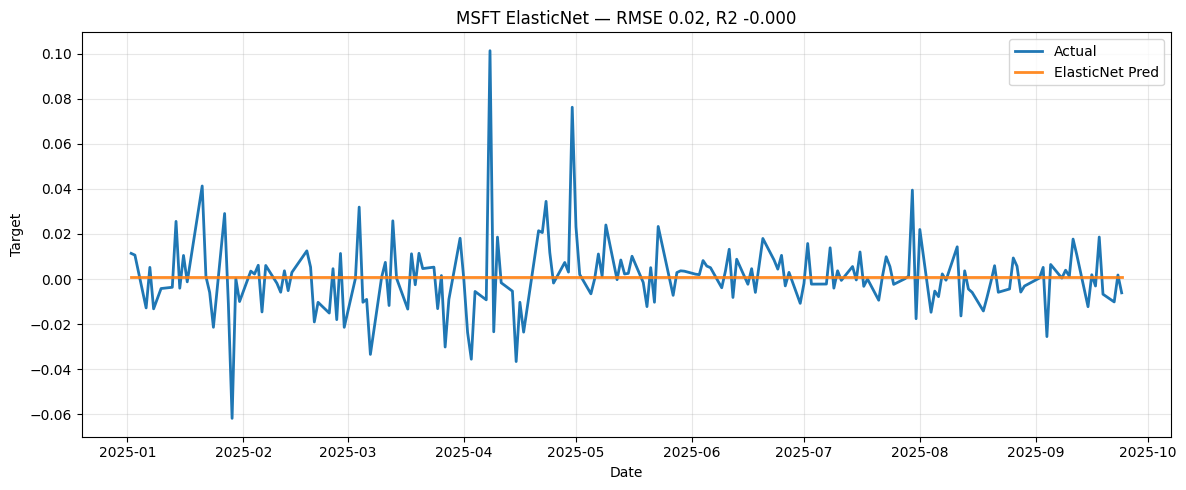

In [6]:
# Test cosa
results = []

for stock, data in data_set.items():

    print(f"\n=== ElasticNet for {stock} ===")
    if len(X_train) == 0 or len(X_test) == 0:
        print("  skipping (empty split)")
        continue

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("enet", ElasticNet(random_state=42, max_iter=20000))
    ])

    param_grid = {
        "enet__alpha": [1e-3, 1e-2, 1e-1, 1.0],
        "enet__l1_ratio": [0.1, 0.5, 0.9]
    }

    gs = GridSearchCV(pipe, param_grid, scoring="neg_mean_squared_error", cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)

    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

    # coefficients (after scaler + enet)
    try:
        coef = pd.Series(best.named_steps['enet'].coef_, index=X_train.columns)
        print("Top coefficients:\n", coef.abs().sort_values(ascending=False).head(10).to_string())
    except Exception:
        pass

    results.append({
        "Stock": stock,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "Params": gs.best_params_
    })

    # Plot actual vs predicted
    plt.figure(figsize=(12,5))
    plt.plot(data["Y_test"].index, data["Y_test"], label="Actual", color="#1f77b4", linewidth=2)
    plt.plot(data["Y_test"].index, y_pred, label="ElasticNet Pred", color="#ff7f0e", linewidth=2, alpha=0.9)
    plt.title(f"{stock} ElasticNet — RMSE {rmse:.2f}, R2 {r2:.3f}")
    plt.xlabel("Date")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()